In [9]:
# -*- coding: utf-8 -*-
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import os

import tensorflow as tf
from keras import backend as K
#from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.optimizers import adam_v2
from keras.layers import Input
from keras.models import Model
from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils
#from keras.callbacks import TensorBoard
from tensorflow.compat.v1.keras.callbacks import TensorBoard

#from keras_frcnn.pascal_voc_parser import get_data
from keras_frcnn.simple_parser import get_data_cluster
from keras_frcnn import resnet as nn

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=tf_config)

sys.setrecursionlimit(40000)

2022-08-25 10:06:28.736106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27786 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2022-08-25 10:06:28.738636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30575 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2022-08-25 10:06:28.741008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30575 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2022-08-25 10:06:28.743425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30575 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

In [18]:
#Bunch of stuff that would normally be passed as commandline args

C = config.Config()

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

C.model_path = '/scratch/r/rbond/jorlo/ml-clusters/models/weights/model_frcnn.hdf5'
C.num_rois = int(32)

C.network = 'resnet50'

C.base_net_weights = nn.get_weight_path()

In [19]:
train_path = '/home/r/rbond/jorlo/dev/Keras-FasterRCNN/cluster_data.txt'

all_imgs, classes_count, class_mapping = get_data_cluster(train_path)

Parsing annotation files
Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).


In [20]:
#train_path = '/project/r/rbond/jorlo/datasets/Pascal_VOC/'

#all_imgs, classes_count, class_mapping = get_data(train_path)

In [71]:
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping

random.shuffle(all_imgs)

num_imgs = len(all_imgs)

train_imgs = [s for s in all_imgs if s['imageset'] == 'train']
test_imgs = [s for s in all_imgs if s['imageset'] == 'val']

print('Num train samples {}'.format(len(train_imgs)))
print('Num test samples {}'.format(len(test_imgs)))

data_gen_train = data_generators.get_anchor_gt_clusters(train_imgs, classes_count, C, nn.get_img_output_length, K.image_data_format(), mode='train')
data_gen_test = data_generators.get_anchor_gt_clusters(test_imgs, classes_count, C, nn.get_img_output_length, K.image_data_format(), mode='test')

Num train samples 1575
Num test samples 269


In [74]:
next(data_gen_train)

test = [next(data_gen_train) for _ in range(2)]

In [84]:
print(test[0][1][0])

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 

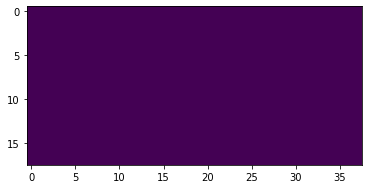

In [86]:
plt.imshow(test[0][1][0][0,...,0])
plt.show()

In [99]:
print(np.amax(test[0][1][0]))
print(test[0][2])

print(np.amax(test[1][1][0]))
print(test[1][2])

1.0
{'filepath': '/project/r/rbond/jorlo/datasets/ml-clusters/indv_images/pos_img_738.hdf5', 'width': 399, 'height': 399, 'bboxes': [{'class': 'cluster', 'x1': 100, 'x2': 300, 'y1': 100, 'y2': 300}], 'imageset': 'train'}
0.0
{'filepath': '/project/r/rbond/jorlo/datasets/ml-clusters/indv_images/neg_img_367.hdf5', 'width': 399, 'height': 399, 'bboxes': [{'class': 'bg', 'x1': 100, 'x2': 300, 'y1': 100, 'y2': 300}], 'imageset': 'train'}


In [46]:
next(data_gen_train)[0]

array([[[[-84.939   , -95.779   , -77.68    ],
         [-84.939   , -95.779   , -77.68    ],
         [-84.939   , -95.779   , -77.68    ],
         ...,
         [ -3.939003, -45.779   , -82.68    ],
         [ -4.939003, -45.779   , -83.68    ],
         [ -4.939003, -46.779   , -83.68    ]],

        [[-84.939   , -95.779   , -77.68    ],
         [-84.939   , -95.779   , -77.68    ],
         [-84.939   , -95.779   , -77.68    ],
         ...,
         [ -4.939003, -46.779   , -82.68    ],
         [ -4.939003, -47.779   , -83.68    ],
         [ -5.939003, -47.779   , -83.68    ]],

        [[-85.939   , -96.779   , -78.68    ],
         [-85.939   , -96.779   , -78.68    ],
         [-84.939   , -95.779   , -77.68    ],
         ...,
         [ -5.939003, -48.779   , -83.68    ],
         [ -5.939003, -48.779   , -84.68    ],
         [ -6.939003, -49.779   , -84.68    ]],

        ...,

        [[-34.939003, -66.779   , -69.68    ],
         [-34.939003, -66.779   , -68.68    ]